In [55]:
!nvidia-smi

Fri Oct 29 04:15:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   5543MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
dir = '/content/drive/My Drive/'
train_data = dir + 'train_data/'
train_label = dir + 'train_label/'
train_label_trans = dir + 'train_label_trans/'
val_data = dir + 'val_data/'
val_label = dir + 'val_label/'
val_label_trans = dir + 'val_label_trans/'
test_data = dir + 'test_data/'
test_label = dir + 'test_label/'
test_label_trans = dir + 'test_label_trans/'
# train_data = dir + 'train_buildings_data/'
# train_label = dir + 'train_buildings_labeling/'

# 데이터 가져오기 확인

In [ ]:
# file_list = [ _ for _ in os.listdir(train_label) if _.endswith(".png") ]
# img = io.imread(os.path.join(train_label, file_list[1011]))

# loc = (img[0][0][0], img[0][0][1], img[0][0][2])

# unique_list = []
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         loc = (img[i][j][0], img[i][j][1], img[i][j][2])
#         if loc not in unique_list:
#             unique_list.append(loc)

# unique_list

[(0, 0, 0),
 (255, 255, 255),
 (0, 0, 255),
 (255, 0, 0),
 (0, 255, 0),
 (0, 255, 255),
 (255, 255, 0)]

- 배경(0): (0,0,0) 검정
- 소형건물(1): (0, 0, 225) 파랑
- 공장(3): (225, 0, 0) 빨강
- 아파트(2): (0, 255, 0) 라임
- 대형건물(5): (0, 225, 225) 아쿠아
- 중형건물(4): (225, 225, 0) 노랑

(1024, 1024, 3)


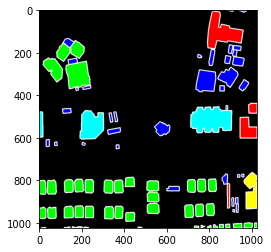

In [ ]:
# def show_image(dir):
#     file_list = [ _ for _ in os.listdir(dir) if _.endswith(".png") ]

#     # for i in range(1000, len(file_list)):
#     plt.figure()
#     img = io.imread(os.path.join(dir, file_list[1011]))
#     print(img.shape)
#     plt.imshow(img)
#         # if i == 5:
#         #     break

# show_image(train_label)
# # shape: (1024, 1024, 3)
# # 총 1238 개 

In [32]:
import os
import matplotlib.pyplot as plt
from skimage import io

(1024, 1024, 3)
(1024, 1024, 3)


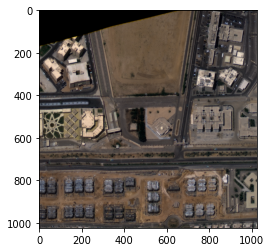

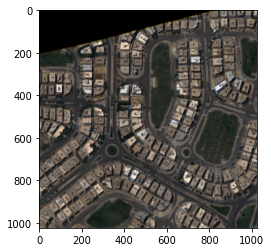

In [33]:
def show_image(dir):
    file_list = [ _ for _ in os.listdir(dir) if _.endswith(".png") ]

    for i in range(len(file_list)):
        plt.figure()
        img = io.imread(os.path.join(dir, file_list[i]))
        print(img.shape)
        plt.imshow(img)
        if i == 5:
            break

show_image(train_data)
# shape: (1024, 1024, 3)
# 총 1238 개 

(1024, 1024, 3)
(1024, 1024, 3)


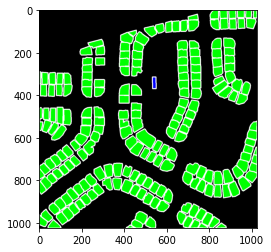

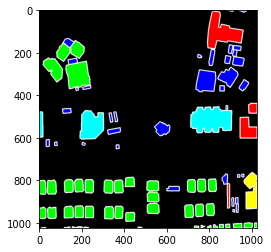

In [63]:
show_image(train_label)

# Lable 데이터 전처리

In [35]:
import os
import cv2
import numpy as np
from PIL import Image

In [36]:
 BUILD_COLORMAP = [
    (0,0,0) , # 배경(0): (0,0,0) 검정
    (0, 0, 255), #소형건물(1): (0, 0, 255) 파랑
    (255, 0, 0) , #공장(3): (255, 0, 0) 빨강
    (0, 255, 0), #아파트(2): (0, 255, 0) 라임
    (0, 255, 255), #대형건물(5): (0, 255, 255) 아쿠아
    (255, 255, 0) #중형건물(4): (255, 255, 0) 노랑
]

def make_label_mask(label):
    label_mask = np.zeros((label.shape[0], label.shape[1]), dtype=np.uint8)
    for cls_index, color_map in enumerate(BUILD_COLORMAP):
        label_mask[np.where(np.all(label == color_map, axis=-1))[:]] = cls_index

    return label_mask

In [37]:
def make_label_trans(org_dir, trans_dir):
    file_list = [ _ for _ in os.listdir(org_dir) if _.endswith(".png") ]

    for i in range(len(file_list)):
        tg_path = os.path.join(trans_dir, file_list[i])
        label = cv2.imread(os.path.join(org_dir, file_list[i]))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        Image.fromarray(make_label_mask(label)).save(tg_path, 'PNG')

(1024, 1024)
(1024, 1024)


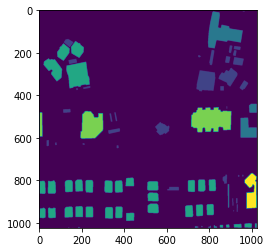

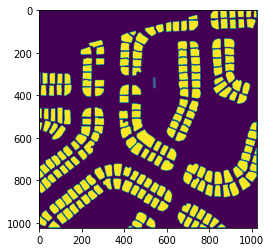

In [38]:
make_label_trans(train_label, train_label_trans)
show_image(train_label_trans)

(1024, 1024, 3)
(1024, 1024, 3)


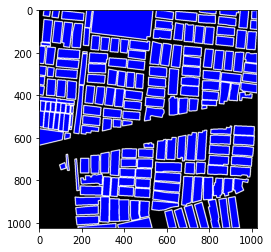

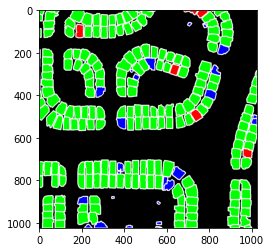

In [39]:
make_label_trans(val_label, val_label_trans)
show_image(val_label_trans)

(1024, 1024)
(1024, 1024)


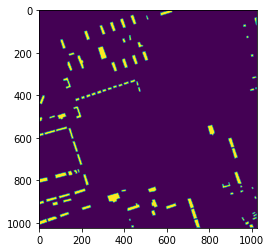

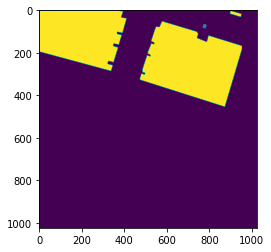

In [65]:
make_label_trans(test_label, test_label_trans)
show_image(test_label_trans)

# 데이터로더 만들기

dataloader.py용

In [40]:
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensor

from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [66]:
__all__ = ["BuildingDataset", "fetch_dataloader"]

class BuildingDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self): 
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        return image, mask #{'image': image, 'mask': mask } 

def fetch_dataloader(types, dir, batch_size, num_workers):
    dataloaders = {}

    for split in types:
        if split == 'train':
            data_dir = os.path.join(dir, 'train_data')
            label_dir = os.path.join(dir, 'train_label_trans')

        elif split == 'val':
            data_dir = os.path.join(dir, 'val_data')
            label_dir = os.path.join(dir, 'val_label_trans')
        
        else:
            data_dir = os.path.join(dir, 'test_data')
            label_dir = os.path.join(dir, 'test_label_trans')

        data_files = [ _ for _ in os.listdir(data_dir) if _.endswith(".png") ] # [:2]
        label_files = [ _ for _ in os.listdir(label_dir) if _.endswith(".png") ]

        data_paths = [os.path.join(data_dir, file_name) for file_name in data_files]
        label_paths = [os.path.join(label_dir, file_name) for file_name in label_files]

        transform = A.Compose([
            # A.LongestMaxSize(max_size=448),
            # A.PadIfNeeded(min_height=448, min_width=448, border_mode=cv2.BORDER_CONSTANT),
            A.Resize(512,512),
            A.Normalize(),
            ToTensor()
        ])

        dl = DataLoader(BuildingDataset(data_paths, label_paths, transform=transform),
                            batch_size,
                            shuffle=True,
                            num_workers=num_workers            
                )
    
        dataloaders[split] = dl

    return dataloaders

In [68]:
# dataloaders = fetch_dataloader(["train", "val", "test"],
#                                 dir=dir,
#                                 batch_size=4,
#                                 num_workers = 2
#                             )
# train_loader, val_loader, test_loader = dataloaders['train'], dataloaders['val'], dataloaders['test']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([2, 3, 512, 512]) torch.Size([2, 1, 512, 512])


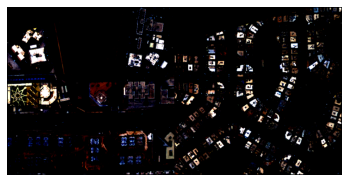

In [43]:
# for i_batch, sample_batch in enumerate(train_loader):
#     image, mask = sample_batch
#     print(i_batch, image.size(), mask.size())
   
#     if i_batch == 0:
#         plt.figure()
#         grid = utils.make_grid(image)
#         plt.imshow(grid.numpy().transpose(1,2,0))
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([2, 3, 512, 512]) torch.Size([2, 1, 512, 512])


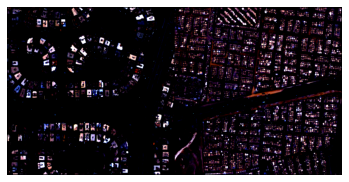

In [44]:
# for i_batch, sample_batch in enumerate(val_loader):
#     image, mask = sample_batch
#     print(i_batch, image.size(), mask.size())
   
#     if i_batch == 0:
#         plt.figure()
#         grid = utils.make_grid(image)
#         plt.imshow(grid.numpy().transpose(1,2,0))
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

# 모델 아키텍처 불러오기

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [70]:
class FCN32s(nn.Module):
    def __init__(self, num_classes=6):
        super(FCN32s, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore32 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 64, stride = 32)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        o_h, o_w = x.size()[2], x.size()[3]
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        upscore32 = self.upscore32(h)  

        u_h, u_w = upscore32.size()[2], upscore32.size()[3]
        dh, dw = (u_h - o_h)//2, (u_w - o_w)//2
        return torch.sigmoid(upscore32[:, :, dh:(dh + o_h), dw:(dw + o_w)])

In [ ]:
class FCN16s(nn.Module):
    def __init__(self, num_classes=6):
        super(FCN16s, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        self.score_pool4 = nn.Conv2d(512, num_classes, 1)

        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 32, stride = 16)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        pool4 = h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        upscore2 = self.upscore2(h)         
        pool4 = self.score_pool4(pool4)

        dh, dw = (pool4.size()[2] - upscore2.size()[2])//2, (pool4.size()[3] - upscore2.size()[3])//2
        upscore16 = self.upscore16(upscore2 + pool4[:, :, dh:(dh + upscore2.size()[2]), dw:(dw + upscore2.size()[3])]) 

        dh, dw = (upscore16.size()[2] - x.size()[2])//2, (upscore16.size()[3] - x.size()[3])//2
        return torch.sigmoid(upscore16[:, :, dh:(dh + x.size()[2]), dw:(dw + x.size()[3])])

In [ ]:
class FCN8s(nn.Module):
    def __init__(self, num_classes=6):
        super(FCN8s, self).__init__()
        self.relu    = nn.ReLU(inplace=True)

        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)

        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore2_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 16, stride = 8)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        pool3 = h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        pool4 = h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        pool3 = self.score_pool3(pool3)
        pool4 = self.score_pool4(pool4)

        h = self.score_fr(h)
        upscore2 = self.upscore2(h)         

        dh, dw = (pool4.size()[2] - upscore2.size()[2])//2, (pool4.size()[3] - upscore2.size()[3])//2
        upscore2_pool4 = self.upscore2_pool4(upscore2 + pool4[:, :, dh:(dh + upscore2.size()[2]), dw:(dw + upscore2.size()[3])])

        dh, dw = (pool3.size()[2] - upscore2_pool4.size()[2])//2, (pool3.size()[3] - upscore2_pool4.size()[3])//2
        upscore8 = self.upscore8(upscore2_pool4 + pool3[:, :, dh:(dh + upscore2_pool4.size()[2]), dw:(dw + upscore2_pool4.size()[3])])

        dh, dw = (upscore8.size()[2] - x.size()[2])//2, (upscore8.size()[3] - x.size()[3])//2
        return torch.sigmoid(upscore8[:, :, dh:(dh + x.size()[2]), dw:(dw + x.size()[3])])

In [47]:
# net = FCN32s()
# for data, mask in train_loader:
#     y = net(data)
#     print(y)
#     print(y.shape)
#     break

tensor([[[[0.5015, 0.5015, 0.5015,  ..., 0.5015, 0.5015, 0.5015],
          [0.5015, 0.5015, 0.5015,  ..., 0.5015, 0.5015, 0.5015],
          [0.5015, 0.5015, 0.5015,  ..., 0.5015, 0.5015, 0.5015],
          ...,
          [0.5015, 0.5015, 0.5015,  ..., 0.5015, 0.5015, 0.5015],
          [0.5015, 0.5015, 0.5015,  ..., 0.5015, 0.5015, 0.5015],
          [0.5015, 0.5015, 0.5015,  ..., 0.5015, 0.5015, 0.5015]],

         [[0.4990, 0.4990, 0.4989,  ..., 0.4990, 0.4990, 0.4990],
          [0.4990, 0.4990, 0.4990,  ..., 0.4990, 0.4990, 0.4990],
          [0.4990, 0.4990, 0.4990,  ..., 0.4990, 0.4990, 0.4990],
          ...,
          [0.4990, 0.4990, 0.4990,  ..., 0.4990, 0.4990, 0.4990],
          [0.4990, 0.4990, 0.4990,  ..., 0.4990, 0.4990, 0.4990],
          [0.4990, 0.4990, 0.4990,  ..., 0.4990, 0.4990, 0.4990]],

         [[0.5010, 0.5009, 0.5009,  ..., 0.5009, 0.5009, 0.5010],
          [0.5009, 0.5010, 0.5009,  ..., 0.5010, 0.5010, 0.5009],
          [0.5010, 0.5010, 0.5010,  ..., 0

# U-Net


In [34]:
__all__ = ['unet', 'UNet', 'UNet_BN']

class CBR(nn.Module):

    def __init__(self, c_in, c_out, k_size, stride, padding):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=k_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(num_features=c_out)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)

        return x

class CR(nn.Module):

    def __init__(self, c_in, c_out, k_size, stride, padding):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=k_size, stride=stride, padding=padding)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)

        return x

class UNet(nn.Module):

    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Contracting path
        self.encoder_1_1 = CR(in_channels, 64, k_size=3, stride=1, padding=1)
        self.encoder_1_2 = CR(64, 64, k_size=3, stride=1, padding=1)
        self.encoder_1_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder_2_1 = CR(64, 128, k_size=3, stride=1, padding=1)
        self.encoder_2_2 = CR(128, 128, k_size=3, stride=1, padding=1)
        self.encoder_2_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder_3_1 = CR(128, 256, k_size=3, stride=1, padding=1)
        self.encoder_3_2 = CR(256, 256, k_size=3, stride=1, padding=1)
        self.encoder_3_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder_4_1 = CR(256, 512, k_size=3, stride=1, padding=1)
        self.encoder_4_2 = CR(512, 512, k_size=3, stride=1, padding=1)
        self.encoder_4_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder_5_1 = CR(512, 1024, k_size=3, stride=1, padding=1)
        self.encoder_5_2 = CR(1024, 1024, k_size=3, stride=1, padding=1)

        # Expansive path
        self.decoder_1_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0)
        self.decoder_1_2 = CR(1024, 512, k_size=3, stride=1, padding=1)
        self.decoder_1_3 = CR(512, 512, k_size=3, stride=1, padding=1)

        self.decoder_2_1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.decoder_2_2 = CR(512, 256, k_size=3, stride=1, padding=1)
        self.decoder_2_3 = CR(256, 256, k_size=3, stride=1, padding=1)

        self.decoder_3_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.decoder_3_2 = CR(256, 128, k_size=3, stride=1, padding=1)
        self.decoder_3_3 = CR(128, 128, k_size=3, stride=1, padding=1)

        self.decoder_4_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.decoder_4_2 = CR(128, 64, k_size=3, stride=1, padding=1)
        self.decoder_4_3 = CR(64, 64, k_size=3, stride=1, padding=1)

        self.pointwise_conv = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding=0)
        
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def forward(self, x):

        # Contracting path
        enc_1_1 = self.encoder_1_1(x)
        enc_1_2 = self.encoder_1_2(enc_1_1)
        pool_1 = self.encoder_1_3(enc_1_2)

        enc_2_1 = self.encoder_2_1(pool_1)
        enc_2_2 = self.encoder_2_2(enc_2_1)
        pool_2 = self.encoder_2_3(enc_2_2)

        enc_3_1 = self.encoder_3_1(pool_2)
        enc_3_2 = self.encoder_3_2(enc_3_1)
        pool_3 = self.encoder_3_3(enc_3_2)

        enc_4_1 = self.encoder_4_1(pool_3)
        enc_4_2 = self.encoder_4_2(enc_4_1)
        pool_4 = self.encoder_4_3(enc_4_2)

        enc_5_1 = self.encoder_5_1(pool_4)
        enc_5_2 = self.encoder_5_2(enc_5_1)

        # Expansive path
        up_conv_1 = self.decoder_1_1(enc_5_2, output_size=enc_4_1.shape[2:])
        dec_1_2 = self.decoder_1_2(torch.cat([enc_4_2, up_conv_1], dim=1))
        dec_1_3 = self.decoder_1_3(dec_1_2)

        up_conv_2 = self.decoder_2_1(dec_1_3, output_size=enc_3_1.shape[2:])
        dec_2_2 = self.decoder_2_2(torch.cat([enc_3_2, up_conv_2], dim=1))
        dec_2_3 = self.decoder_2_3(dec_2_2)

        up_conv_3 = self.decoder_3_1(dec_2_3, output_size=enc_2_1.shape[2:])
        dec_3_2 = self.decoder_3_2(torch.cat([enc_2_2, up_conv_3], dim=1))
        dec_3_3 = self.decoder_3_3(dec_3_2)

        up_conv_4 = self.decoder_4_1(dec_3_3, output_size=enc_1_1.shape[2:])
        dec_4_2 = self.decoder_4_2(torch.cat([enc_1_2, up_conv_4], dim=1))
        dec_4_3 = self.decoder_4_3(dec_4_2)
        
        out = self.pointwise_conv(dec_4_3)

        return out

class UNet_BN(nn.Module):

    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Contracting path
        self.encoder_1_1 = CBR(in_channels, 64, k_size=3, stride=1, padding=1)
        self.encoder_1_2 = CBR(64, 64, k_size=3, stride=1, padding=1)
        self.encoder_1_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder_2_1 = CBR(64, 128, k_size=3, stride=1, padding=1)
        self.encoder_2_2 = CBR(128, 128, k_size=3, stride=1, padding=1)
        self.encoder_2_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder_3_1 = CBR(128, 256, k_size=3, stride=1, padding=1)
        self.encoder_3_2 = CBR(256, 256, k_size=3, stride=1, padding=1)
        self.encoder_3_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder_4_1 = CBR(256, 512, k_size=3, stride=1, padding=1)
        self.encoder_4_2 = CBR(512, 512, k_size=3, stride=1, padding=1)
        self.encoder_4_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.encoder_5_1 = CBR(512, 1024, k_size=3, stride=1, padding=1)
        self.encoder_5_2 = CBR(1024, 1024, k_size=3, stride=1, padding=1)

        # Expansive path
        self.decoder_1_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0)
        self.decoder_1_2 = CBR(1024, 512, k_size=3, stride=1, padding=1)
        self.decoder_1_3 = CBR(512, 512, k_size=3, stride=1, padding=1)

        self.decoder_2_1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.decoder_2_2 = CBR(512, 256, k_size=3, stride=1, padding=1)
        self.decoder_2_3 = CBR(256, 256, k_size=3, stride=1, padding=1)

        self.decoder_3_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.decoder_3_2 = CBR(256, 128, k_size=3, stride=1, padding=1)
        self.decoder_3_3 = CBR(128, 128, k_size=3, stride=1, padding=1)

        self.decoder_4_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.decoder_4_2 = CBR(128, 64, k_size=3, stride=1, padding=1)
        self.decoder_4_3 = CBR(64, 64, k_size=3, stride=1, padding=1)

        self.pointwise_conv = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding=0)
        
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def forward(self, x):

        # Contracting path
        enc_1_1 = self.encoder_1_1(x)
        enc_1_2 = self.encoder_1_2(enc_1_1)
        pool_1 = self.encoder_1_3(enc_1_2)

        enc_2_1 = self.encoder_2_1(pool_1)
        enc_2_2 = self.encoder_2_2(enc_2_1)
        pool_2 = self.encoder_2_3(enc_2_2)

        enc_3_1 = self.encoder_3_1(pool_2)
        enc_3_2 = self.encoder_3_2(enc_3_1)
        pool_3 = self.encoder_3_3(enc_3_2)

        enc_4_1 = self.encoder_4_1(pool_3)
        enc_4_2 = self.encoder_4_2(enc_4_1)
        pool_4 = self.encoder_4_3(enc_4_2)

        enc_5_1 = self.encoder_5_1(pool_4)
        enc_5_2 = self.encoder_5_2(enc_5_1)

        # Expansive path
        up_conv_1 = self.decoder_1_1(enc_5_2, output_size=enc_4_1.shape[2:])
        dec_1_2 = self.decoder_1_2(torch.cat([enc_4_2, up_conv_1], dim=1))
        dec_1_3 = self.decoder_1_3(dec_1_2)

        up_conv_2 = self.decoder_2_1(dec_1_3, output_size=enc_3_1.shape[2:])
        dec_2_2 = self.decoder_2_2(torch.cat([enc_3_2, up_conv_2], dim=1))
        dec_2_3 = self.decoder_2_3(dec_2_2)

        up_conv_3 = self.decoder_3_1(dec_2_3, output_size=enc_2_1.shape[2:])
        dec_3_2 = self.decoder_3_2(torch.cat([enc_2_2, up_conv_3], dim=1))
        dec_3_3 = self.decoder_3_3(dec_3_2)

        up_conv_4 = self.decoder_4_1(dec_3_3, output_size=enc_1_1.shape[2:])
        dec_4_2 = self.decoder_4_2(torch.cat([enc_1_2, up_conv_4], dim=1))
        dec_4_3 = self.decoder_4_3(dec_4_2)
        
        out = self.pointwise_conv(dec_4_3)

        return out


def unet(in_channels, num_classes, use_batchnorm=False):
    if use_batchnorm:
        return UNet_BN(in_channels, num_classes)
    else:
        return UNet(in_channels, num_classes)

In [53]:
# net = unet(3, 6)
# for data, mask in train_loader:
#     y = net(data)
#     print(y)
#     print(y.shape)

# SegNet


In [22]:
class SegNet(nn.Module):
    """SegNet: A Deep Convolutional Encoder-Decoder Architecture for
    Image Segmentation. https://arxiv.org/abs/1511.00561
    See https://github.com/alexgkendall/SegNet-Tutorial for original models.
    Args:
        num_classes (int): number of classes to segment
        n_init_features (int): number of input features in the fist convolution
        drop_rate (float): dropout rate of each encoder/decoder module
        filter_config (list of 5 ints): number of output features at each level
    """
    def __init__(self, num_classes, n_init_features=3, drop_rate=0.5,
                 filter_config=(64, 128, 256, 512, 512)):
        super(SegNet, self).__init__()

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        # setup number of conv-bn-relu blocks per module and number of filters
        encoder_n_layers = (2, 2, 3, 3, 3)
        encoder_filter_config = (n_init_features,) + filter_config
        decoder_n_layers = (3, 3, 3, 2, 1)
        decoder_filter_config = filter_config[::-1] + (filter_config[0],)

        for i in range(0, 5):
            # encoder architecture
            self.encoders.append(_Encoder(encoder_filter_config[i],
                                          encoder_filter_config[i + 1],
                                          encoder_n_layers[i], drop_rate))

            # decoder architecture
            self.decoders.append(_Decoder(decoder_filter_config[i],
                                          decoder_filter_config[i + 1],
                                          decoder_n_layers[i], drop_rate))

        # final classifier (equivalent to a fully connected layer)
        self.classifier = nn.Conv2d(filter_config[0], num_classes, 3, 1, 1)

    def forward(self, x):
        indices = []
        unpool_sizes = []
        feat = x

        # encoder path, keep track of pooling indices and features size
        for i in range(0, 5):
            (feat, ind), size = self.encoders[i](feat)
            indices.append(ind)
            unpool_sizes.append(size)

        # decoder path, upsampling with corresponding indices and size
        for i in range(0, 5):
            feat = self.decoders[i](feat, indices[4 - i], unpool_sizes[4 - i])

        return self.classifier(feat)


class _Encoder(nn.Module):
    def __init__(self, n_in_feat, n_out_feat, n_blocks=2, drop_rate=0.5):
        """Encoder layer follows VGG rules + keeps pooling indices
        Args:
            n_in_feat (int): number of input features
            n_out_feat (int): number of output features
            n_blocks (int): number of conv-batch-relu block inside the encoder
            drop_rate (float): dropout rate to use
        """
        super(_Encoder, self).__init__()

        layers = [nn.Conv2d(n_in_feat, n_out_feat, 3, 1, 1),
                  nn.BatchNorm2d(n_out_feat),
                  nn.ReLU(inplace=True)]

        if n_blocks > 1:
            layers += [nn.Conv2d(n_out_feat, n_out_feat, 3, 1, 1),
                       nn.BatchNorm2d(n_out_feat),
                       nn.ReLU(inplace=True)]
            if n_blocks == 3:
                layers += [nn.Dropout(drop_rate)]

        self.features = nn.Sequential(*layers)

    def forward(self, x):
        output = self.features(x)
        return F.max_pool2d(output, 2, 2, return_indices=True), output.size()


class _Decoder(nn.Module):
    """Decoder layer decodes the features by unpooling with respect to
    the pooling indices of the corresponding decoder part.
    Args:
        n_in_feat (int): number of input features
        n_out_feat (int): number of output features
        n_blocks (int): number of conv-batch-relu block inside the decoder
        drop_rate (float): dropout rate to use
    """
    def __init__(self, n_in_feat, n_out_feat, n_blocks=2, drop_rate=0.5):
        super(_Decoder, self).__init__()

        layers = [nn.Conv2d(n_in_feat, n_in_feat, 3, 1, 1),
                  nn.BatchNorm2d(n_in_feat),
                  nn.ReLU(inplace=True)]

        if n_blocks > 1:
            layers += [nn.Conv2d(n_in_feat, n_out_feat, 3, 1, 1),
                       nn.BatchNorm2d(n_out_feat),
                       nn.ReLU(inplace=True)]
            if n_blocks == 3:
                layers += [nn.Dropout(drop_rate)]

        self.features = nn.Sequential(*layers)

    def forward(self, x, indices, size):
        unpooled = F.max_unpool2d(x, indices, 2, 2, 0, size)
        return self.features(unpooled)

In [43]:
# net = SegNet(6)
# for data, mask in train_loader:
#     y = net(data)
#     print(y)
#     print(y.shape)

tensor([[[[-0.0551,  0.1343,  0.0822,  ..., -0.2304,  0.0291, -0.0312],
          [ 0.0547,  0.0733, -0.0498,  ...,  0.0011, -0.0675, -0.0346],
          [-0.2818, -0.2409, -0.2160,  ..., -0.4511,  0.0222, -0.0144],
          ...,
          [-0.2527,  0.3142,  0.1689,  ..., -0.0690, -0.0112,  0.0195],
          [ 0.0057,  0.1663,  0.3740,  ...,  0.0152, -0.2343, -0.0534],
          [-0.0669,  0.1345,  0.2289,  ...,  0.1474,  0.2030,  0.0062]],

         [[-0.0918, -0.3618, -0.0494,  ..., -0.1775, -0.1179, -0.2079],
          [-0.0967, -0.1245, -0.1513,  ..., -0.0744, -0.3002, -0.0900],
          [ 0.3351,  0.3045,  0.1468,  ..., -0.3825, -0.1565,  0.0714],
          ...,
          [ 0.0262, -0.4263, -0.1136,  ..., -0.2505, -0.0963,  0.1560],
          [ 0.1292, -0.5245,  0.0720,  ..., -0.0226,  0.0705, -0.2121],
          [ 0.2125,  0.0057,  0.0658,  ..., -0.2743, -0.1985, -0.0516]],

         [[-0.2220, -0.0196, -0.0603,  ...,  0.2278,  0.0751, -0.0023],
          [-0.3133,  0.1805,  

# Metric.py용

In [71]:
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from albumentations.augmentations.functional import center_crop

In [72]:
__all__ = ['Evaluator', 'train', 'validation']

class Evaluator():
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def reset(self):
        self.count = np.zeros(self.num_classes, dtype=np.int32)
        self.iou = np.zeros(self.num_classes, dtype=np.float32)
        self.acc = np.zeros(self.num_classes, dtype=np.float32)

    def predict_masks(self, outputs):
        pred_masks = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        return pred_masks

    def evaluate(self, data_loader, model, device):
        running_miou = []
        running_macc = []
        tbar = tqdm(data_loader, desc="evaluation steps", total=len(data_loader))

        model.eval()
        with torch.no_grad():
            for images, gt_masks in tbar:
                images, gt_masks = images.to(device), gt_masks.to(device).long()

                score_masks = model(images)
                pred_masks = self.predict_masks(score_masks)

                for pd_msk, gt_msk in zip(pred_masks.cpu().numpy().astype(np.uint8),
                                        gt_masks.cpu().numpy().astype(np.uint8)):

                    class_list = np.unique(gt_msk)
                    for class_idx in class_list:
                        intersection = ((class_idx == gt_msk) & (class_idx == pd_msk)).astype(np.float32).sum()
                        union = ((class_idx == gt_msk) | (class_idx == pd_msk)).astype(np.float32).sum()
                        gt_pixel = (class_idx == gt_msk).astype(np.float32).sum()

                        self.iou[class_idx] += intersection / union
                        self.acc[class_idx] += intersection / gt_pixel
                        self.count[class_idx] += 1

    def get_metrics(self):
        iou = self.iou / self.count
        pixel_acc = self.acc / self.count

        mean_iou = np.mean(iou)
        mean_acc = np.mean(pixel_acc)

        return iou, pixel_acc, mean_iou, mean_acc

In [73]:
def train(data_loader, model, loss_fn, optimizer, device):
    running_loss = []
    tbar = tqdm(data_loader, desc="train steps", total=len(data_loader))
    
    model.train()
    for images, gt_masks in tbar:
        images, gt_masks = images.to(device), gt_masks.to(device).long()

        optimizer.zero_grad()
        score_masks = model(images)
        loss = loss_fn(score_masks, gt_masks.squeeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
            
    return np.mean(running_loss)


def validation(data_loader, model, loss_fn, device):
    running_loss = []
    tbar = tqdm(data_loader, desc="valid steps", total=len(data_loader))
    
    model.eval()
    with torch.no_grad():
        for images, gt_masks in tbar:
            images, gt_masks = images.to(device), gt_masks.to(device).long()

            score_masks = model(images)
            loss = loss_fn(score_masks, gt_masks.squeeze(1))

            running_loss.append(loss.item())
            
    return np.mean(running_loss)

# main.py용

In [74]:
import os
import argparse
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import SGD, lr_scheduler
from torch.utils.tensorboard import SummaryWriter

# from models import unet
# from models import Evaluator, train, validation
# from datasets import fetch_dataloader

In [77]:
parser = argparse.ArgumentParser()

parser.add_argument("--dir", default=dir, type=str,
                    help="Directory containing the dataset")

parser.add_argument("--save_dir", default="experiments", type=str,
                    help="Directory containing model checkpoints")

parser.add_argument("--tensorboard_dir", default="runs", type=str,
                    help="Directory containing tensorboard events")

parser.add_argument("--num_classes", default=6, type=int,
                    help="Number of classes")

parser.add_argument("--epochs", default=5, type=int,
                    help="Number of epochs")

parser.add_argument("--batch_size", default=2, type=int,
                    help="Number of mini-batch size")

parser.add_argument("--learning_rate", default=0.1, type=float,
                    help="Initial learning rate")

args = parser.parse_args("")
# data directory path check
assert os.path.exists(args.dir), "Directory does not exist!"
# save directory path check
if not os.path.exists(args.save_dir):
    os.mkdir("experiments")

torch.manual_seed(11)
if torch.cuda.is_available():
    torch.cuda.manual_seed(11)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
dataloaders = fetch_dataloader(["train", "val", "test"],
                                dir=dir,
                                batch_size=4,
                                num_workers = 2
                            )
train_loader, val_loader, test_loader = dataloaders['train'], dataloaders['val'], dataloaders['test']

model = FCN32s(args.num_classes)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=args.learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                            factor=0.1,
                                            patience=5)

writer = SummaryWriter(os.path.join(args.tensorboard_dir, "fcn32"))
evaluator = Evaluator(args.num_classes)
best_mean_iou = 0
    
for epoch in range(args.epochs):
    # train
    train_loss = train(train_loader, model, loss_fn, optimizer, device)

    # validation
    val_loss = validation(val_loader, model, loss_fn, device)

    # evaluate miou, pixel accuracy
    evaluator.reset()
    evaluator.evaluate(test_loader, model, device)
    iou, pixel_acc, mean_iou, mean_acc = evaluator.get_metrics()

    print((f"Epoch {epoch + 1}/{args.epochs}\n"
            f"[Train] loss: {train_loss:.3f}\n"
            f"[Valid] loss: {val_loss:.3f}, mIoU: {mean_iou:.3f}, Mean Accuracy: {mean_acc:.3f}"))

    writer.add_scalars("Loss", {"train": train_loss, "valid": val_loss}, epoch + 1)
    writer.add_scalar("Mean IoU", mean_iou, epoch + 1)
    writer.add_scalar("Mean Accuracy", mean_acc, epoch + 1)
    writer.add_scalars("IoU", 
        {"0. 배경": iou[0],
        "1. 소형건물":  iou[1],
        "2. 아파트":    iou[2],
        "3. 공장":       iou[3],
        "4. 중형건물":       iou[4],
        "5. 대형건물":     iou[5],
        }, epoch + 1)
    writer.add_scalars("Pixel_Accuracy", 
        {"0. 배경": pixel_acc[0],
        "1. 소형건물":   pixel_acc[1],
        "2. 아파트":     pixel_acc[2],
        "3. 공장":        pixel_acc[3],
        "4. 중형건물":        pixel_acc[4],
        "5. 대형건물":      pixel_acc[5],
        }, epoch + 1)

    if (mean_iou > best_mean_iou):
        torch.save({"epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict()},
                    os.path.join(args.save_dir, f"unet_best_miou_{mean_iou:.3f}.tar"))
        best_mean_iou = mean_iou
        print(f"Saved best model - best_miou: {best_mean_iou:.3f}")

    scheduler.step(val_loss)
    
writer.close()

evaluation steps: 100%|██████████| 1/1 [00:13<00:00, 13.69s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Epoch 1/5
[Train] loss: 1.793
[Valid] loss: 1.788, mIoU: nan, Mean Accuracy: nan


evaluation steps: 100%|██████████| 1/1 [00:13<00:00, 13.94s/it]


Epoch 2/5
[Train] loss: 1.787
[Valid] loss: 1.784, mIoU: nan, Mean Accuracy: nan


valid steps:   0%|          | 0/1 [00:00<?, ?it/s]